In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Activation, Dense,LSTM,Dropout
from sklearn.metrics import mean_absolute_error
plt.style.use('fivethirtyeight')

In [2]:
import requests
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [3]:
# Database related all the code is moved to this file
%run -i "SqlConn.py"
#importing local py file
import SqlConn 

In [4]:
#Fetch Tweets and Sentiment data - Join from Tweet and Sentiment tables
try:
    df_dbFinanceData = SqlConn.fetchFinanceData("")
    print("Data transfer Done")
except BaseException as err:
    print(err)

Data transfer Done


In [5]:
df_dbFinanceData

,financeType,date,open,high,low,close,adjustedClose,volume,id
0,tesla,2010-06-29,3.800000,5.000000,3.508000,4.778000,4.778000,93831500,1
1,tesla,2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500,2
2,tesla,2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000,3
3,tesla,2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000,4
4,tesla,2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500,5
...,...,...,...,...,...,...,...,...,...
6916,doge,2022-07-09,0.069224,0.070009,0.068995,0.069512,0.069512,254272147,6917
6917,doge,2022-07-10,0.069509,0.069509,0.066533,0.067263,0.067263,299810124,6918
6918,doge,2022-07-11,0.067268,0.067268,0.061535,0.061847,0.061847,326125900,6919
6919,doge,2022-07-12,0.061851,0.062861,0.060087,0.060087,0.060087,298462083,6920


In [6]:
twitter_price = df_dbFinanceData[df_dbFinanceData["financeType"] == "twitter"]

In [7]:
twitter_price

,financeType,date,open,high,low,close,adjustedClose,volume,id
3030,twitter,2013-11-07,45.099998,50.090000,44.000000,44.900002,44.900002,117701600,3031
3031,twitter,2013-11-08,45.930000,46.939999,40.689999,41.650002,41.650002,27925300,3032
3032,twitter,2013-11-11,40.500000,43.000000,39.400002,42.900002,42.900002,16113900,3033
3033,twitter,2013-11-12,43.660000,43.779999,41.830002,41.900002,41.900002,6316700,3034
3034,twitter,2013-11-13,41.029999,42.869999,40.759998,42.599998,42.599998,8688300,3035
...,...,...,...,...,...,...,...,...,...
5208,twitter,2022-07-06,38.209999,38.450001,37.740002,38.209999,38.209999,4870300,5209
5209,twitter,2022-07-07,38.320000,39.509998,38.320000,38.790001,38.790001,13214900,5210
5210,twitter,2022-07-08,37.509998,37.549999,36.799999,36.810001,36.810001,26156700,5211
5211,twitter,2022-07-11,34.599998,34.900002,32.549999,32.650002,32.650002,67071300,5212


In [8]:
end_date = twitter_price['date'].iloc[-1]
end_date

'2022-07-12'

In [9]:
twitter_price['date'] = pd.to_datetime(twitter_price['date'], format='%Y-%m-%d')

SqlConn.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
twitter_price.dtypes

financeType              object
date             datetime64[ns]
open                    float64
high                    float64
low                     float64
close                   float64
adjustedClose           float64
volume                    int64
id                        int64
dtype: object

In [11]:
twitter_price.set_index("date",inplace = True)

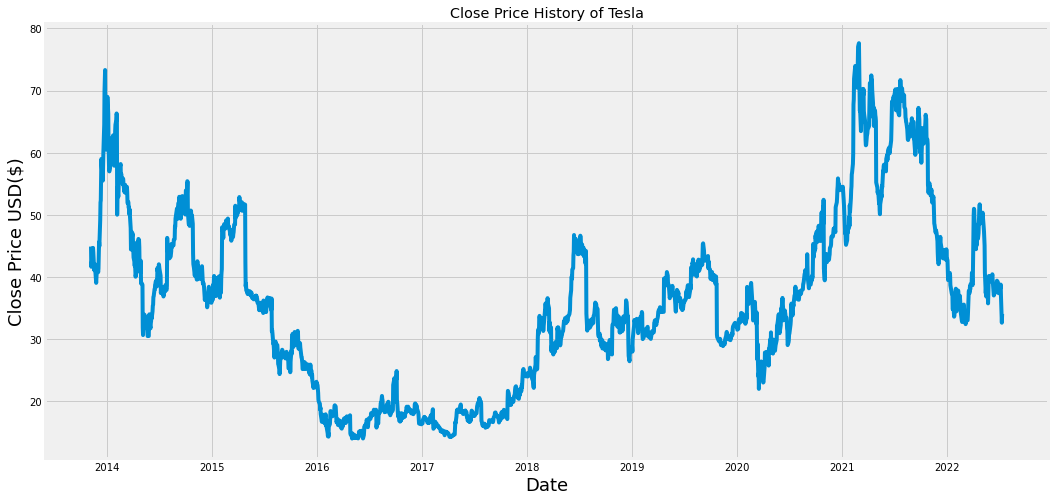

In [12]:
plt.figure(figsize=(16,8))
plt.title('Close Price History of Tesla')
plt.plot(twitter_price['close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD($)',fontsize=18)
plt.show()

In [13]:
data = twitter_price.drop(['financeType','open', 'high', 'low', 'adjustedClose', 'volume','id'], axis = 1)
price_column = 'close'
data.head()

,close
date,
2013-11-07,44.900002
2013-11-08,41.650002
2013-11-11,42.900002
2013-11-12,41.900002
2013-11-13,42.599998


In [14]:
# This function splits the data in 70,30 ratio.
def train_test_split(df, test_size=0.3):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [15]:
train, test = train_test_split(data, test_size=0.2)

In [16]:
train.shape, test.shape

((1747, 1), (436, 1))

In [17]:
train

,close
date,
2013-11-07,44.900002
2013-11-08,41.650002
2013-11-11,42.900002
2013-11-12,41.900002
2013-11-13,42.599998
...,...
2020-10-09,45.900002
2020-10-12,48.250000
2020-10-13,47.000000


In [18]:
test

,close
date,
2020-10-16,45.810001
2020-10-19,45.820000
2020-10-20,46.349998
2020-10-21,50.240002
2020-10-22,50.279999
...,...
2022-07-06,38.209999
2022-07-07,38.790001
2022-07-08,36.810001


In [19]:
# Perform MinMax scaling
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(data).reshape(-1,1))
df1

array([[0.48553919],
       [0.43445463],
       [0.45410254],
       ...,
       [0.3583779 ],
       [0.29298967],
       [0.3151525 ]])

In [20]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.8)
# test_size=len(df1)-training_size

test_size = 0.2
split_row = len(df1) - int(test_size * len(df1))
# train_data = df.iloc[:split_row]
# test_data = df.iloc[split_row:]
    
train_scaled,test_scaled=df1[0:split_row,:],df1[split_row:,]
training_size,split_row

(1746, 1747)

In [21]:
train_scaled.shape,test_scaled.shape

((1747, 1), (436, 1))

In [22]:
train_scaled

array([[0.48553919],
       [0.43445463],
       [0.45410254],
       ...,
       [0.51854765],
       [0.50251496],
       [0.50330086]])

In [23]:
test_scaled

array([[0.49984286],
       [0.50000002],
       [0.50833071],
       [0.56947507],
       [0.57010375],
       [0.57261868],
       [0.54998431],
       [0.58566491],
       [0.54259668],
       [0.60389817],
       [0.4298963 ],
       [0.40018865],
       [0.43571206],
       [0.45190191],
       [0.46683434],
       [0.45756052],
       [0.4586608 ],
       [0.44640052],
       [0.4655769 ],
       [0.45268787],
       [0.46321914],
       [0.45143039],
       [0.45331656],
       [0.46086142],
       [0.46541969],
       [0.48208113],
       [0.48616788],
       [0.49072621],
       [0.5095882 ],
       [0.51210314],
       [0.51084564],
       [0.51336057],
       [0.52216287],
       [0.53096515],
       [0.53002203],
       [0.53269418],
       [0.52530653],
       [0.52216287],
       [0.5847218 ],
       [0.58833701],
       [0.59745366],
       [0.61002832],
       [0.62904748],
       [0.63847851],
       [0.65796921],
       [0.63863566],
       [0.64287963],
       [0.633

In [24]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [25]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 30
X_train, y_train = create_dataset(train_scaled, time_step)
X_test, ytest = create_dataset(test_scaled, time_step)

In [26]:
print(X_train.shape), print(y_train.shape)

(1716, 30)
(1716,)


(None, None)

In [27]:
print(X_test.shape), print(ytest.shape)

(405, 30)
(405,)


(None, None)

In [28]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [29]:
print(X_train.shape), print(y_train.shape)

(1716, 30, 1)
(1716,)


(None, None)

In [30]:
print(X_test.shape), print(ytest.shape)

(405, 30, 1)
(405,)


(None, None)

In [31]:
X_test

array([[[0.49984286],
        [0.50000002],
        [0.50833071],
        ...,
        [0.49072621],
        [0.5095882 ],
        [0.51210314]],

       [[0.50000002],
        [0.50833071],
        [0.56947507],
        ...,
        [0.5095882 ],
        [0.51210314],
        [0.51084564]],

       [[0.50833071],
        [0.56947507],
        [0.57010375],
        ...,
        [0.51210314],
        [0.51084564],
        [0.51336057]],

       ...,

       [[0.37488215],
        [0.34187361],
        [0.3638793 ],
        ...,
        [0.38069791],
        [0.38305568],
        [0.38038353]],

       [[0.34187361],
        [0.3638793 ],
        [0.40097456],
        ...,
        [0.38305568],
        [0.38038353],
        [0.38950019]],

       [[0.3638793 ],
        [0.40097456],
        [0.41119144],
        ...,
        [0.38038353],
        [0.38950019],
        [0.3583779 ]]])

In [32]:
ytest

array([0.51084564, 0.51336057, 0.52216287, 0.53096515, 0.53002203,
       0.53269418, 0.52530653, 0.52216287, 0.5847218 , 0.58833701,
       0.59745366, 0.61002832, 0.62904748, 0.63847851, 0.65796921,
       0.63863566, 0.64287963, 0.63329143, 0.62810442, 0.63533483,
       0.63423456, 0.63376303, 0.63093373, 0.63690665, 0.62668977,
       0.61694435, 0.60232637, 0.58896576, 0.53709528, 0.5191764 ,
       0.5220057 , 0.49952849, 0.48994029, 0.50172904, 0.52797862,
       0.52043383, 0.53520909, 0.53175105, 0.56051556, 0.53725245,
       0.59038041, 0.57403333, 0.60751339, 0.62857595, 0.63769261,
       0.66802892, 0.67227289, 0.69459294, 0.72084252, 0.84501728,
       0.85743478, 0.90993406, 0.94231377, 0.90820503, 0.91559266,
       0.91590697, 0.88777115, 0.92989627, 0.91024836, 0.95221627,
       0.99104057, 1.        , 0.93775544, 0.89358698, 0.82898464,
       0.83212825, 0.7775857 , 0.8410877 , 0.79880548, 0.85586296,
       0.85020435, 0.88447032, 0.86828046, 0.88321282, 0.82851

In [33]:
np.random.seed(42)
tf.random.set_seed(42)
window_len = 30
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 100
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'
activ_func = "relu"

In [34]:
# model = Sequential()
# model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Dropout(dropout))
# model.add(Dense(units=1))
# model.add(Activation(activ_func))
# model.compile(loss=loss, optimizer=optimizer)
# model.summary()

In [35]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [36]:
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/100
54/54 [==============================] - 9s 33ms/step - loss: 0.0088
Epoch 2/100
54/54 [==============================] - 2s 33ms/step - loss: 0.0026
Epoch 3/100
54/54 [==============================] - 2s 33ms/step - loss: 0.0021
Epoch 4/100
54/54 [==============================] - 2s 33ms/step - loss: 0.0019
Epoch 5/100
54/54 [==============================] - 2s 33ms/step - loss: 0.0016
Epoch 6/100
54/54 [==============================] - 2s 34ms/step - loss: 0.0015
Epoch 7/100
54/54 [==============================] - 2s 38ms/step - loss: 0.0016
Epoch 8/100
54/54 [==============================] - 2s 34ms/step - loss: 0.0014
Epoch 9/100
54/54 [==============================] - 2s 33ms/step - loss: 0.0012
Epoch 10/100
54/54 [==============================] - 2s 34ms/step - loss: 0.0011
Epoch 11/100
54/54 [==============================] - 2s 34ms/step - loss: 0.0010
Epoch 12/100
54/54 [==============================] - 2s 33ms/step - loss: 0.0010
Epoch 13/100
54/54 [=====

54/54 [==============================] - 2s 43ms/step - loss: 3.9652e-04
Epoch 97/100
54/54 [==============================] - 2s 42ms/step - loss: 3.7424e-04
Epoch 98/100
54/54 [==============================] - 2s 42ms/step - loss: 3.6592e-04
Epoch 99/100
54/54 [==============================] - 2s 42ms/step - loss: 3.8724e-04
Epoch 100/100
54/54 [==============================] - 2s 42ms/step - loss: 4.1829e-04


In [37]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

13/13 [==============================] - 0s 14ms/step


In [38]:
test_predict

array([[0.5025765 ],
       [0.5010095 ],
       [0.5038167 ],
       [0.5132473 ],
       [0.5223243 ],
       [0.52095795],
       [0.52340883],
       [0.5158166 ],
       [0.5128829 ],
       [0.57691944],
       [0.57662547],
       [0.58340883],
       [0.59505796],
       [0.61404693],
       [0.62263227],
       [0.6423635 ],
       [0.6217087 ],
       [0.6300846 ],
       [0.6213839 ],
       [0.61803305],
       [0.6257332 ],
       [0.62318265],
       [0.62160325],
       [0.61768544],
       [0.62306356],
       [0.6116189 ],
       [0.60243416],
       [0.58863133],
       [0.5764135 ],
       [0.5257247 ],
       [0.5087268 ],
       [0.5116373 ],
       [0.4891288 ],
       [0.47762787],
       [0.4881066 ],
       [0.51409984],
       [0.5053601 ],
       [0.5186621 ],
       [0.51518506],
       [0.54487085],
       [0.5219096 ],
       [0.5771523 ],
       [0.55937   ],
       [0.5945435 ],
       [0.61399347],
       [0.62143964],
       [0.6516259 ],
       [0.652

In [39]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

0.01961006122259445

In [40]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

0.035690827229633924

In [41]:
# Calculate the Mean Absolute Error
from sklearn.metrics import mean_absolute_error
mae=mean_absolute_error(ytest,test_predict)
mae

0.026535311882672413

In [42]:
# Calculate Mean Absolute error using Sklearn library
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(ytest,test_predict)

0.04183003854401259

In [43]:
# Manual calculation of Mean Absolute Percentage error.
total = 0
for i,j in zip(ytest, test_predict):
    value = abs(i-j)/abs(i)
    total+= value
#     print(total)
error = float(total*100/(len(ytest))) # Calculate MAPE
mape = round(error,2) # round to 3 significant figures
print(mape)

4.18


In [44]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [45]:
test_predict.shape

(405, 1)

In [46]:
targets = test[price_column][window_len+1:]
targets

date
2020-12-01    46.669998
2020-12-02    47.230000
2020-12-03    47.790001
2020-12-04    47.730000
2020-12-07    47.900002
                ...    
2022-07-06    38.209999
2022-07-07    38.790001
2022-07-08    36.810001
2022-07-11    32.650002
2022-07-12    34.060001
Name: close, Length: 405, dtype: float64

In [47]:
preds = pd.Series(index=targets.index, data=test_predict.squeeze())
preds

date
2020-12-01    45.983913
2020-12-02    45.884224
2020-12-03    46.062817
2020-12-04    46.662792
2020-12-07    47.240273
                ...    
2022-07-06    37.714657
2022-07-07    38.001373
2022-07-08    37.825195
2022-07-11    38.316257
2022-07-12    36.442112
Length: 405, dtype: float32

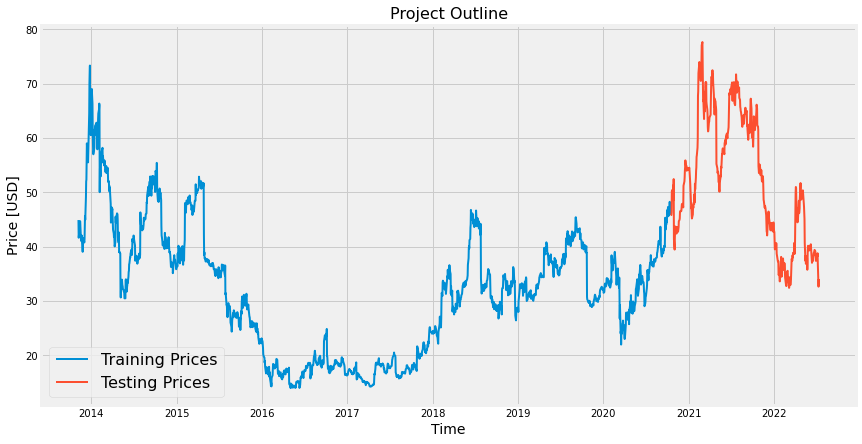

In [48]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('Price [USD]', fontsize=14)
    ax.set_xlabel('Time', fontsize = 14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
line_plot(train["close"], test["close"], 'Training Prices', 'Testing Prices', title='Project Outline')

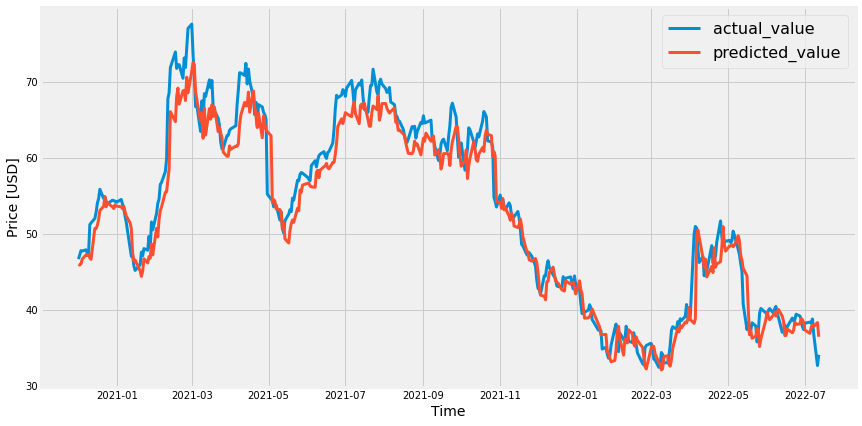

In [49]:
line_plot(targets, preds, 'actual_value', 'predicted_value', lw=3)

### Future Prediction for 30 days

In [70]:
len(test)

436

In [71]:
length = len(test_scaled)
length

436

In [72]:
#Getting the last 100 days records
fut_inp = test_scaled[length-30:]
fut_inp.shape

(30, 1)

In [73]:
fut_inp = fut_inp.reshape(1,-1)

In [74]:
fut_inp.shape

(1, 30)

In [75]:
fut_inp

array([[0.41119144, 0.40223199, 0.39751651, 0.4071047 , 0.41103429,
        0.4016033 , 0.41056275, 0.4154354 , 0.40113172, 0.39248666,
        0.3618359 , 0.36482242, 0.37692554, 0.36702298, 0.37362465,
        0.39138637, 0.38541339, 0.38777116, 0.39924554, 0.39578749,
        0.38950019, 0.37393901, 0.3674945 , 0.38069791, 0.38305568,
        0.38038353, 0.38950019, 0.3583779 , 0.29298967, 0.3151525 ]])

In [76]:
tmp_inp = list(fut_inp)

In [77]:
tmp_inp

[array([0.41119144, 0.40223199, 0.39751651, 0.4071047 , 0.41103429,
        0.4016033 , 0.41056275, 0.4154354 , 0.40113172, 0.39248666,
        0.3618359 , 0.36482242, 0.37692554, 0.36702298, 0.37362465,
        0.39138637, 0.38541339, 0.38777116, 0.39924554, 0.39578749,
        0.38950019, 0.37393901, 0.3674945 , 0.38069791, 0.38305568,
        0.38038353, 0.38950019, 0.3583779 , 0.29298967, 0.3151525 ])]

In [78]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [79]:
tmp_inp

[0.41119143718287177,
 0.4022319900455197,
 0.3975165072705048,
 0.4071047032586309,
 0.41103428533641695,
 0.4016033040680589,
 0.41056275120541097,
 0.4154354015452091,
 0.4011317227820679,
 0.39248665792926696,
 0.3618359020042078,
 0.36482241581998187,
 0.37692554433789094,
 0.36702298178354187,
 0.3736246482375658,
 0.39138637494748685,
 0.3854133944709238,
 0.3877711594359238,
 0.39924553910305893,
 0.395787491156279,
 0.3895001912684779,
 0.37393901480378877,
 0.36749450019621976,
 0.38069791169590894,
 0.3830556766609089,
 0.3803835294113579,
 0.3895001912684779,
 0.35837790121241275,
 0.29298967115638175,
 0.3151524983567666]

In [80]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=30
i=0
while(i<30):
    
    if(len(tmp_inp)>30):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.29995670914649963], [0.2932637929916382], [0.2872181236743927], [0.2813528776168823], [0.2754366397857666], [0.26941221952438354], [0.26336604356765747], [0.2574481666088104], [0.25179818272590637], [0.2465047687292099], [0.24160264432430267], [0.2370692789554596], [0.23285919427871704], [0.22891056537628174], [0.22515305876731873], [0.22153247892856598], [0.21801091730594635], [0.21455784142017365], [0.21116118133068085], [0.20782096683979034], [0.20453821122646332], [0.2013174146413803], [0.19816109538078308], [0.1950749158859253], [0.19206896424293518], [0.1891465038061142], [0.18630865216255188], [0.1835588961839676], [0.18088483810424805], [0.17826679348945618]]


In [81]:
end_date

'2022-07-12'

In [82]:
temp = pd.to_datetime(end_date, format='%Y-%m-%d')
temp
end_date_new = temp.strftime('%m/%d/%Y')
end_date_new

'07/12/2022'

In [83]:
preds = scaler.inverse_transform(lst_output)
preds

array([[33.09324494],
       [32.66744163],
       [32.28281617],
       [31.90966923],
       [31.5332782 ],
       [31.1500046 ],
       [30.7653469 ],
       [30.38885159],
       [30.02939963],
       [29.69263265],
       [29.38075951],
       [29.09234682],
       [28.82450124],
       [28.57328948],
       [28.33423692],
       [28.10389564],
       [27.8798539 ],
       [27.66016923],
       [27.44407372],
       [27.23156929],
       [27.02272038],
       [26.81781332],
       [26.61700829],
       [26.42066556],
       [26.22942693],
       [26.0435    ],
       [25.86295589],
       [25.68801642],
       [25.51789286],
       [25.35133287]])

In [84]:
import datetime
date_future = temp + datetime.timedelta(41)
date_future_str = date_future.strftime('%m/%d/%Y')
date_future_str

'08/22/2022'

In [85]:
c = pd.date_range(start=end_date_new, end=date_future_str, freq='B')
c

DatetimeIndex(['2022-07-12', '2022-07-13', '2022-07-14', '2022-07-15',
               '2022-07-18', '2022-07-19', '2022-07-20', '2022-07-21',
               '2022-07-22', '2022-07-25', '2022-07-26', '2022-07-27',
               '2022-07-28', '2022-07-29', '2022-08-01', '2022-08-02',
               '2022-08-03', '2022-08-04', '2022-08-05', '2022-08-08',
               '2022-08-09', '2022-08-10', '2022-08-11', '2022-08-12',
               '2022-08-15', '2022-08-16', '2022-08-17', '2022-08-18',
               '2022-08-19', '2022-08-22'],
              dtype='datetime64[ns]', freq='B')

In [86]:
len(c)

30

In [87]:
fut_preds = pd.Series(index=c, data=preds.squeeze())
fut_preds

2022-07-12    33.093245
2022-07-13    32.667442
2022-07-14    32.282816
2022-07-15    31.909669
2022-07-18    31.533278
2022-07-19    31.150005
2022-07-20    30.765347
2022-07-21    30.388852
2022-07-22    30.029400
2022-07-25    29.692633
2022-07-26    29.380760
2022-07-27    29.092347
2022-07-28    28.824501
2022-07-29    28.573289
2022-08-01    28.334237
2022-08-02    28.103896
2022-08-03    27.879854
2022-08-04    27.660169
2022-08-05    27.444074
2022-08-08    27.231569
2022-08-09    27.022720
2022-08-10    26.817813
2022-08-11    26.617008
2022-08-12    26.420666
2022-08-15    26.229427
2022-08-16    26.043500
2022-08-17    25.862956
2022-08-18    25.688016
2022-08-19    25.517893
2022-08-22    25.351333
Freq: B, dtype: float64

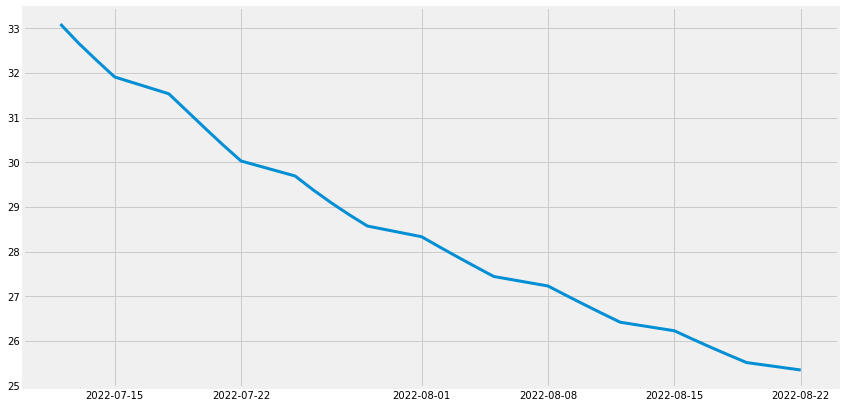

In [88]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(fut_preds, label="predicted value_30", linewidth=3)

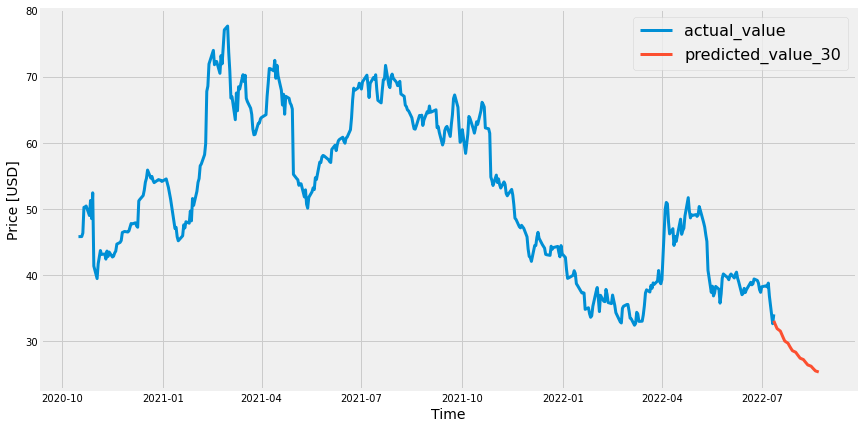

In [69]:
line_plot(test["close"], fut_preds, 'actual_value', 'predicted_value_30', lw=3)